# Modelo estatístico de previsão de chuva

**Sala: 2A**

**Grupo:**
> Breno Marti

> Diogo Cintra

> João Pedro Chacon Ruiz

> Luiz Felipe Valente

___
## • Imports

Importando as devidas funções para que se possa fazer a análise e filtragem dos dados, bem como a implementação do modelo de regrassão multipla.

In [38]:
#Importando as bibliotecas
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import arange
from numpy import percentile
import numpy as np
from pandas import DataFrame
from scipy.stats import probplot
import statsmodels.api as sm

## • Início da análise exploratória

Antes que se possa partir para a emplementação de qualquer modelo de previsão é necessário, primeiramente,  que se entenda como os dados se comportam e, caso preciso, manipulá-los, de forma a facilitar a construção do modelo, mas sem comprometer seus conteúdos.

In [39]:
dados1 = pd.read_excel('sao_paulo.xlsx')
dados1.head();

In [40]:
datas = dados1.data
horas = dados1.hora

In [41]:
concat = []
for e in range(len(datas)):
    #concat.append(datas[e] + ',' + horas[e])
    d = datas[e]
    d = d.replace(hour=horas[e], minute=0, second=0)
    concat.append(d)
    
#print(concat)
dia_hora = pd.DataFrame(concat)

In [42]:
dados1.insert(0,'time', dia_hora, True);

In [43]:
dados_2 = dados1.drop(['data', 'hora'], axis=1)
dados_3 = dados_2.set_index("time")

dados2 = dados1.drop(['data', 'hora'], axis=1)
dados2.dropna();

## Definindo as variáveis que vamos estudar 

A partir de estudos e leitura de papeis sobre o tema, as seguintes variáveis foram, repetidamente, dadas como as mais relevantes: temperatura, umidade, pressão atmosférica e velociadade do vento. Com base nessas pesquisas, estas mesmas foram tomadas como variáveis independentes do modelo de regressão linear múltipla.

In [44]:
dados_log = np.log(dados_3[['temp_inst','pressao','umid_inst','precipitacao','vento_vel']])

dados3 = dados2.transpose()
dados4 = dados3.loc[['time','temp_inst', 'pressao','umid_inst', 'precipitacao','vento_vel']]
dados5 = dados4.transpose()
dados5 = dados5.sort_values(by='time')
dados5 = dados5.reset_index()
del dados5['index']
d = dados5.dropna()

/Users/joaopedrochacon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [45]:
data = []
hora = []

for coisas in d.time.astype(str):
    teste = coisas.split()
    data.append(teste[0])
    horas = teste[1]
    hora.append(horas[0:2])

In [46]:
final = []

anterior = data[0]
a=0
day = 0
for dia in data:
    if a < 8744:
        if data[a+1] == anterior:
            final.append(day)
        else:
            final.append(day)
            day += 1
            anterior = data[a+1]
    a += 1
final.append(364)

In [47]:
hora = pd.Series(hora).astype(int) 
final = pd.Series(final).astype(int)

In [48]:
d['horas'] = hora
d['dias'] = final

/Users/joaopedrochacon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/joaopedrochacon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Criando as colunas de seno e de cosseno tanto das horas quanto dos dias para dar ao modelo a ideia de que são variáveis cíclicas

Estas variáveis foram criadas para representar a sazonalidade nos períodos de chuva, a fim de aumentar a precisão do modelo, que agora será capaz de distinguir as diferentes estações do ano.

In [49]:
d['hora_seno'] = np.sin(2*np.pi*hora/24)
d['hora_cosseno'] = np.cos(2*np.pi*hora/24)

/Users/joaopedrochacon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/joaopedrochacon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
d['dia_seno'] = np.sin(2*np.pi*final/365.25)
d['dia_cosseno'] = np.cos(2*np.pi*final/365.25)
d.head()

/Users/joaopedrochacon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/joaopedrochacon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,time,temp_inst,pressao,umid_inst,precipitacao,vento_vel,horas,dias,hora_seno,hora_cosseno,dia_seno,dia_cosseno
0,2018-11-18 00:00:00,17.7,928.7,94,0,116,0.0,0.0,0.000000,1.000000,0.0,1.0
1,2018-11-18 01:00:00,17.5,928.6,94,0,120,1.0,0.0,0.258819,0.965926,0.0,1.0
2,2018-11-18 02:00:00,17.2,928,96,0,134,2.0,0.0,0.500000,0.866025,0.0,1.0
3,2018-11-18 03:00:00,18.5,927.5,93,0,34,3.0,0.0,0.707107,0.707107,0.0,1.0
4,2018-11-18 04:00:00,19.8,926.4,87,0,354,4.0,0.0,0.866025,0.500000,0.0,1.0


___
## Analisando os dias que tiveram chuvas

### Análise com log

In [51]:
dados_log_com_chuva = dados_log[dados_log['precipitacao']>0]
dados_log_com_chuva.head()

,temp_inst,pressao,umid_inst,precipitacao,vento_vel
time,,,,,
2018-11-18 22:00:00,3.077312,6.829145,4.543295,0.336472,5.707110
2018-11-19 02:00:00,2.856470,6.831954,4.543295,0.587787,5.129899
2018-11-19 19:00:00,2.714695,6.833355,4.543295,0.182322,5.023881
2018-11-19 00:00:00,2.867899,6.831738,4.543295,2.128232,5.393628
2018-11-19 07:00:00,2.833213,6.830010,4.564348,0.470004,5.141664


In [52]:
temperatura1_log = dados_log_com_chuva['temp_inst']
pressao1_log = dados_log_com_chuva['pressao']
umidade1_log = dados_log_com_chuva['umid_inst']
precipitacao1_log = dados_log_com_chuva['precipitacao']

### Análise de correlação entre variáveis independentes

Uma grande correlação entre variáveis independentes comprometem a análise por serem redundantes entre sí, impedindo que o algoritmo atribua valores relevantes às mesmas variáveis

Scatter plots a fim de facilitar a visualização da correlação entre as variáveis

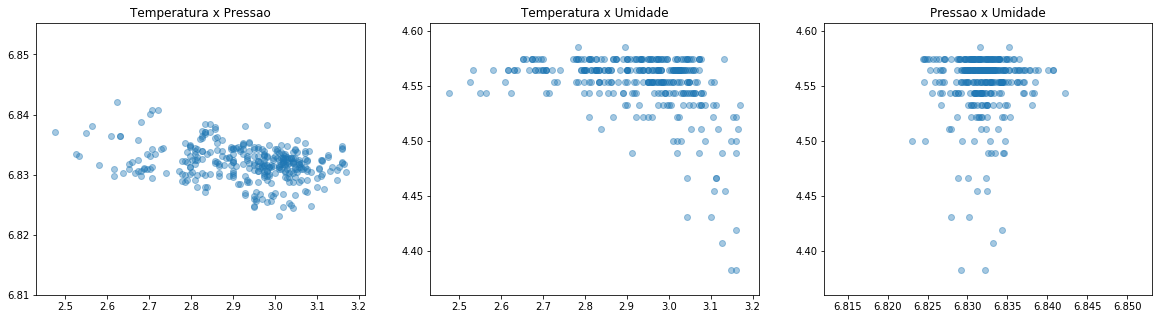

In [53]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5) 
axs[0].scatter(temperatura1_log,pressao1_log, alpha=0.4);
axs[0].set_title('Temperatura x Pressao');
axs[1].scatter(temperatura1_log,umidade1_log, alpha=0.4);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao1_log,umidade1_log, alpha=0.4);
axs[2].set_title('Pressao x Umidade');

### Análise sem log

Novamente, se trata de uma análise a fim de selecionar variáveis independentes que de fato contribuam com o modelo

In [54]:
dados_com_chuva = dados5[dados5['precipitacao']>0]
dados_com_chuva.head()

,time,temp_inst,pressao,umid_inst,precipitacao,vento_vel
22,2018-11-18 22:00:00,21.7,924.4,94,1.4,301
23,2018-11-18 23:00:00,22,925.4,95,0.4,200
24,2018-11-19 00:00:00,17.6,926.8,94,8.4,220
25,2018-11-19 01:00:00,17.5,927.2,95,6.8,157
26,2018-11-19 02:00:00,17.4,927,94,1.8,169


In [55]:
tempo1 = dados_com_chuva['time']
temperatura1 = dados_com_chuva['temp_inst']
pressao1 = dados_com_chuva['pressao']
umidade1 = dados_com_chuva['umid_inst']
precipitacao1 = dados_com_chuva['precipitacao']

temperatura1 = temperatura1.astype(float)
umidade1 = umidade1.astype(float)
pressao1 = pressao1.astype(float)
precipitacao1 = precipitacao1.astype(float)

temperatura1_log = temperatura1_log.astype(float)
umidade1_log = umidade1_log.astype(float)
pressao1_log = pressao1_log.astype(float)
precipitacao1_log = precipitacao1_log.astype(float)

Scatter plots das variáveis independentes, que passam uma imagem visual da correlação entre elas

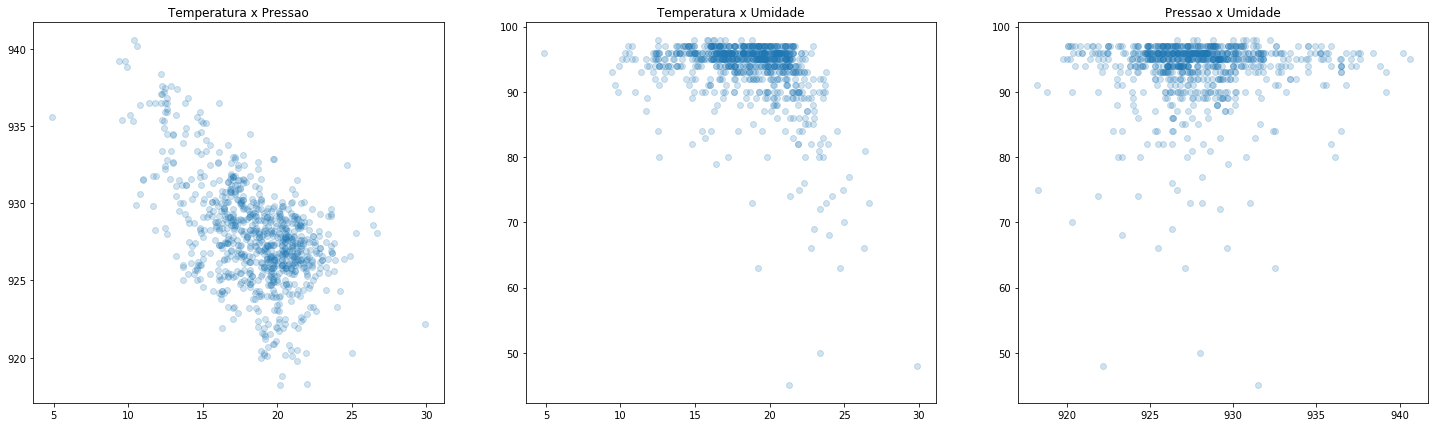

In [56]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(25, 7) 
axs[0].scatter(temperatura1,pressao1, alpha=0.2);
axs[0].set_title('Temperatura x Pressao');
axs[1].scatter(temperatura1,umidade1, alpha=0.2);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao1,umidade1, alpha=0.2);
axs[2].set_title('Pressao x Umidade');

### Correlação entre as variáveis independentes

Cálculo do valor númerico das correlações entre as variáveis independentes

> Sem uso de log

In [57]:
print('Correlação entre temperatura e pressão:', temperatura1.corr(pressao1))
print('Correlação entre temperatura e umidade:', temperatura1.corr(umidade1))
print('Correlação entre pressão e umidade:',pressao1.corr(umidade1))

Correlação entre temperatura e pressão: -0.5488528251274664
Correlação entre temperatura e umidade: -0.3464574364736255
Correlação entre pressão e umidade: 0.03197843875839696


> Com uso de log

In [58]:
print('Correlação entre temperatura e pressão:', np.log10(temperatura1).corr(pressao1))
print('Correlação entre temperatura e umidade:', np.log10(temperatura1).corr(umidade1))
print('Correlação entre pressão e umidade:',np.log10(pressao1).corr(umidade1))

Correlação entre temperatura e pressão: -0.5721111786077637
Correlação entre temperatura e umidade: -0.28976593886799085
Correlação entre pressão e umidade: 0.03208389615743958


O uso de logaritmos nos valores das variáveis ajuda, em certos casos, a mostrar correlações que antes não eram percebidas dado a sua natureza

Scatter plot das variáveis independentes x dependentes com logaritmo, a fim de visualizar possíveis correlações 

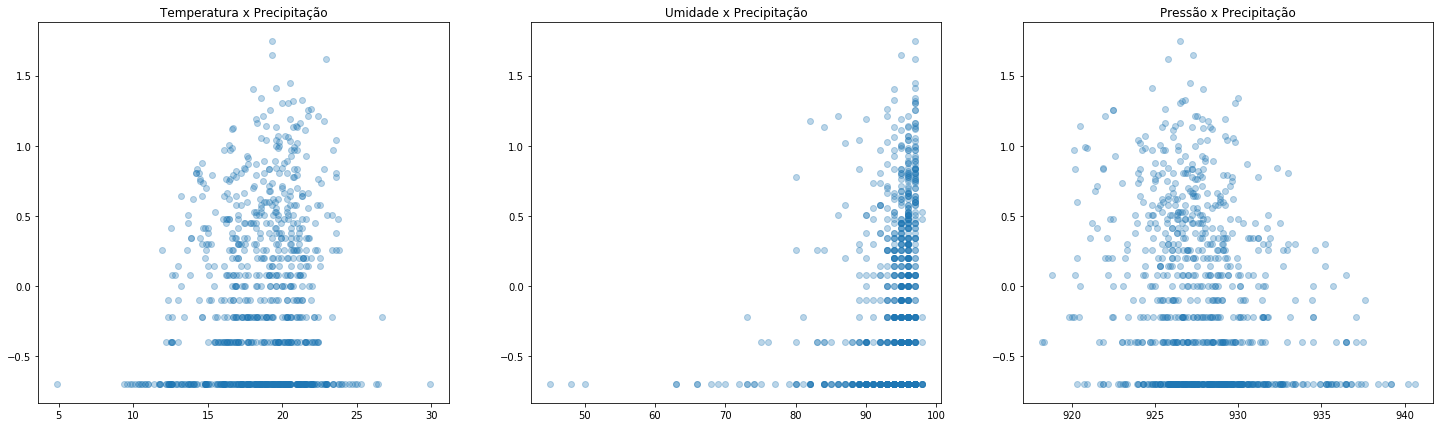

In [59]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(25, 7) 
axs[0].scatter(temperatura1,np.log10(precipitacao1), alpha=0.3);
axs[0].set_title('Temperatura x Precipitação');
axs[1].scatter(umidade1,np.log10(precipitacao1), alpha=0.3);
axs[1].set_title('Umidade x Precipitação');
axs[2].scatter(pressao1,np.log10(precipitacao1), alpha=0.3);
axs[2].set_title('Pressão x Precipitação');

### Correlação entre as variáveis independentes e a variável dependente

Este cálculo é crucial para que se perceba quais variáveis podem, de fato contribuir para o modelo. Essa possível contribuição depende da correlação entre as variáveis independentes escolhidas e a variável dependente a ser calculada

> Cálculo sem usar o logaritmo

In [60]:
print('Correlação entre precipitação e pressão:',(precipitacao1).corr(pressao1))
print('Correlação entre precipitação e umidade:',(precipitacao1).corr(umidade1))
print('Correlação entre precipitação e umidade:',(precipitacao1).corr(temperatura1))

Correlação entre precipitação e pressão: -0.16590337399187374
Correlação entre precipitação e umidade: 0.13346501296565053
Correlação entre precipitação e umidade: 0.12463014239076822


> Cálculo usando o logaritmo

In [61]:
print('Correlação entre precipitação e pressão:', np.log10(precipitacao1).corr(pressao1))
print('Correlação entre precipitação e umidade:', np.log10(precipitacao1).corr(umidade1))
print('Correlação entre precipitação e umidade:',np.log10(precipitacao1).corr(temperatura1))

Correlação entre precipitação e pressão: -0.2602460154313453
Correlação entre precipitação e umidade: 0.2526373920276481
Correlação entre precipitação e umidade: 0.13454309530266464


## Plot de tabelas OLS

As tabelas OLS são usadas para que se possa ter uma noção de como os dados se comportam e como se dão cetos parâmetros relevântes para a análise

In [62]:
model = sm.OLS(np.log10(precipitacao1),sm.add_constant(umidade1))
results = model.fit()
results.summary()

/Users/joaopedrochacon/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     57.06
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           1.11e-13
Time:                        15:20:37   Log-Likelihood:                -728.23
No. Observations:                 839   AIC:                             1460.
Df Residuals:                     837   BIC:                             1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6851      0.345     -7.789      0.000      -3.362      -2.008
umid_inst      0.0278      0.004      7.554      0.000       0.021       0.035
==============================================================================
Omnibus:                       68.672   Durbin-Watson:                   1.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.697
Skew:                           0.552   Prob(JB):                     4.88e-13
Kurtosis:                       2.367   Cond. No.                     1.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
model = sm.OLS(precipitacao1,sm.add_constant(umidade1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     15.18
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           0.000106
Time:                        15:20:38   Log-Likelihood:                -2452.4
No. Observations:                 839   AIC:                             4909.
Df Residuals:                     837   BIC:                             4918.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.1628      2.691     -3.033      0.002     -13.445      -2.880
umid_inst      0.1120      0.029      3.896      0.000       0.056       0.168
==============================================================================
Omnibus:                      921.911   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65119.273
Skew:                           5.277   Prob(JB):                         0.00
Kurtosis:                      44.850   Cond. No.                     1.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [64]:
model = sm.OLS(precipitacao1,sm.add_constant(temperatura1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     13.21
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           0.000296
Time:                        15:20:38   Log-Likelihood:                -2453.4
No. Observations:                 839   AIC:                             4911.
Df Residuals:                     837   BIC:                             4920.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2215      0.983     -1.243      0.214      -3.151       0.708
temp_inst      0.1906      0.052      3.634      0.000       0.088       0.294
==============================================================================
Omnibus:                      916.875   Durbin-Watson:                   1.503
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64599.242
Skew:                           5.226   Prob(JB):                         0.00
Kurtosis:                      44.697   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

___
## Analisando os dias que não tiveram chuvas

##### Análise com log

In [65]:
dados_log_sem_chuva = dados_log[dados_log['precipitacao']==0]
dados_log_sem_chuva.head()

,temp_inst,pressao,umid_inst,precipitacao,vento_vel
time,,,,,
2018-11-19 06:00:00,2.862201,6.829577,4.553877,0.0,5.164786
2018-11-23 22:00:00,2.975530,6.829469,4.564348,0.0,4.912655
2018-12-23 06:00:00,2.995732,6.829794,4.564348,0.0,5.736572
2019-01-06 01:00:00,3.030134,6.833247,4.564348,0.0,4.672829
2019-02-15 20:00:00,3.058707,6.824917,4.543295,0.0,4.691348


In [66]:
temperatura2_log = dados_log_com_chuva['temp_inst']
pressao2_log = dados_log_com_chuva['pressao']
umidade2_log = dados_log_com_chuva['umid_inst']
precipitacao2_log = dados_log_com_chuva['precipitacao']

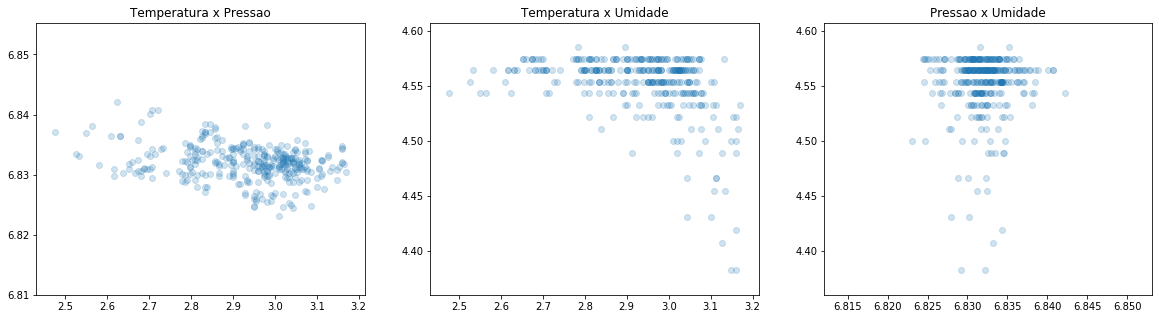

In [67]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5) 
axs[0].scatter(temperatura2_log,pressao2_log, alpha=0.2);
axs[0].set_title('Temperatura x Pressao');
axs[1].scatter(temperatura2_log,umidade2_log, alpha=0.2);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao2_log,umidade2_log, alpha=0.2);
axs[2].set_title('Pressao x Umidade');

##### Análise sem log

In [68]:
dados_sem_chuva = dados5[dados5['precipitacao']==0]
dados_sem_chuva.head()

,time,temp_inst,pressao,umid_inst,precipitacao,vento_vel
0,2018-11-18 00:00:00,17.7,928.7,94,0,116
1,2018-11-18 01:00:00,17.5,928.6,94,0,120
2,2018-11-18 02:00:00,17.2,928,96,0,134
3,2018-11-18 03:00:00,18.5,927.5,93,0,34
4,2018-11-18 04:00:00,19.8,926.4,87,0,354


In [69]:
tempo2 = dados_sem_chuva['time']
temperatura2 = dados_sem_chuva['temp_inst']
pressao2 = dados_sem_chuva['pressao']
umidade2 = dados_sem_chuva['umid_inst']
precipitacao2 = dados_sem_chuva['precipitacao']

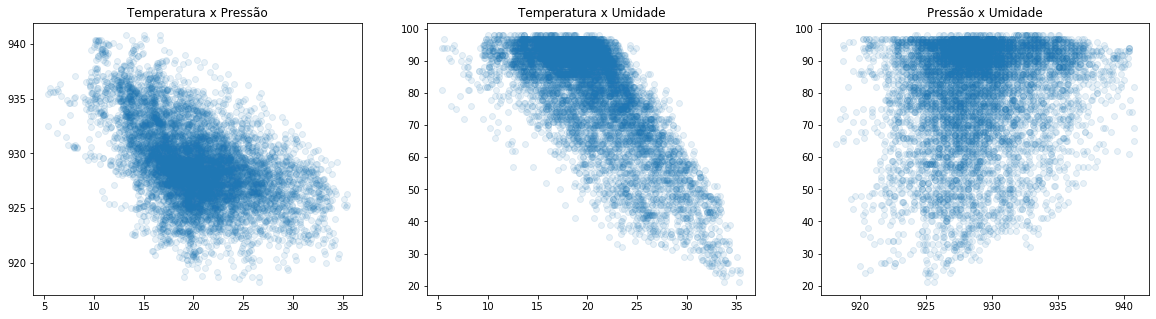

In [70]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5) 
axs[0].scatter(temperatura2,pressao2, alpha=0.1);
axs[0].set_title('Temperatura x Pressão');
axs[1].scatter(temperatura2,umidade2, alpha=0.1);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao2,umidade2, alpha=0.1);
axs[2].set_title('Pressão x Umidade');

***Valores de correlação entre as variáveis***

In [71]:
temperatura2 = temperatura2.astype(float)
umidade2 = umidade2.astype(float)
pressao2 = pressao2.astype(float)
print('Correlação entre temperatura e pressão:', temperatura2.corr(pressao2))
print('Correlação entre temperatura e umidade:', temperatura2.corr(umidade2))
print('Correlação entre pressão e umidade:',pressao2.corr(umidade2))

Correlação entre temperatura e pressão: -0.4953857855829225
Correlação entre temperatura e umidade: -0.7203896264385546
Correlação entre pressão e umidade: 0.1461915872654267


## Esclarecendo a mudança de DataSet

Com os dados anteriores, mesmo após muitas manipulações e iterações, as correlações das variáveis independentes com a variável dependente eram muito baixas. A partir dos estudos feitos, era certeza que temperatura, pressão, umidade e velocidade do vento tinham impacto no regime de chuvas, logo, a nossa escolha de variáveis independentes não estava equivocada.

Sabendo disso, foi feito um esforço para que se compreendesse o motivo do comportamento incoerente do nosso DataSet em comparação com as pesquisas feitas anteriormente. Ao fim, chegou-se à hipótese de que a própria estação de coleta de dados poderia ser um problema, dado que as mesmas se encontravam em cidades não tão relevantes dentro do país.

Dessa forma, para tentar solucionar o problema, uma estação em São Paulo, a maior e mais importante cidade do Brasil foi selecionada, com base na ideia de que sua relevância significaria dados de maior qualidade quando comparados com os anteriores. O resultado desta troca foi satisfátorio, dado como as correlações das variáveis independentes com a variável dependente aumentaram consideravelmente, tanto numéricamente por meio do cálculo ca correlação quanto visualmente, por meio dos Scatter Plots realizados 

____

## Organização de DataFrames

> Estes são feitos a fim de possibilitar a análise do evento a partir dos dados advindos das horas que o precedem e do instante em sí

In [72]:
dados6 = d.set_index('time')
dados7 = dados6[['temp_inst','pressao','umid_inst','precipitacao','vento_vel']]
D = dados7.astype(float)
D.head()

,temp_inst,pressao,umid_inst,precipitacao,vento_vel
time,,,,,
2018-11-18 00:00:00,17.7,928.7,94.0,0.0,116.0
2018-11-18 01:00:00,17.5,928.6,94.0,0.0,120.0
2018-11-18 02:00:00,17.2,928.0,96.0,0.0,134.0
2018-11-18 03:00:00,18.5,927.5,93.0,0.0,34.0
2018-11-18 04:00:00,19.8,926.4,87.0,0.0,354.0


In [119]:
t = [] #hora de chuva
t1 = [] #uma hora anterior
t2 = [] #duas horas anteriores
t3 = [] #tres horas anteriores
t4 = [] #quatro horas anteriores

for e in range(len(D)):
    
    if D['precipitacao'][e]>0:
        t.append(D.iloc[e])
        t1.append(D.iloc[e-1])
        t2.append(D.iloc[e-2])
        t3.append(D.iloc[e-3])
        t4.append(D.iloc[e-4])

# Guardando as listas como DataFrames
T = pd.DataFrame(t)
T1 = pd.DataFrame(t1)
T2 = pd.DataFrame(t2)
T3 = pd.DataFrame(t3)
T4 = pd.DataFrame(t4)

# Renomeando as colunas de todos estes DataFrames -  0 Horas
T.rename(columns={'temp_inst':'temperatura_t'}, inplace=True)
T.rename(columns={'pressao':'pressao_t'}, inplace=True)
T.rename(columns={'umid_inst':'umidade_t'}, inplace=True)
T.rename(columns={'precipitacao':'precipitacao_t'}, inplace=True)
T.rename(columns={'vento_vel':'vento_t'}, inplace=True)
T[['temperatura_t', 'pressao_t', 'umidade_t','precipitacao_t','vento_t']].astype(float);

# Renomeando as colunas de todos estes DataFrames -  1 Hora atrás
T1.rename(columns={'temp_inst':'temperatura_t1'}, inplace=True)
T1.rename(columns={'pressao':'pressao_t1'}, inplace=True)
T1.rename(columns={'umid_inst':'umidade_t1'}, inplace=True)
T1.rename(columns={'precipitacao':'precipitacao_t1'}, inplace=True)
T1.rename(columns={'vento_vel':'vento_t1'}, inplace=True)
T1[['temperatura_t1', 'pressao_t1', 'umidade_t1','precipitacao_t1','vento_t1']].astype(float);

# Renomeando as colunas de todos estes DataFrames -  2 Horas atrás
T2.rename(columns={'temp_inst':'temperatura_t2'}, inplace=True)
T2.rename(columns={'pressao':'pressao_t2'}, inplace=True)
T2.rename(columns={'umid_inst':'umidade_t2'}, inplace=True)
T2.rename(columns={'precipitacao':'precipitacao_t2'}, inplace=True)
T2.rename(columns={'vento_vel':'vento_t2'}, inplace=True)
T2[['temperatura_t2', 'pressao_t2', 'umidade_t2','precipitacao_t2','vento_t2']].astype(float);

# Renomeando as colunas de todos estes DataFrames -  3 Horas atrás
T3.rename(columns={'temp_inst':'temperatura_t3'}, inplace=True)
T3.rename(columns={'pressao':'pressao_t3'}, inplace=True)
T3.rename(columns={'umid_inst':'umidade_t3'}, inplace=True)
T3.rename(columns={'precipitacao':'precipitacao_t3'}, inplace=True)
T3.rename(columns={'vento_vel':'vento_t3'}, inplace=True)
T3[['temperatura_t3', 'pressao_t3', 'umidade_t3','precipitacao_t3','vento_t3']].astype(float);

# Renomeando as colunas de todos estes DataFrames -  4 Horas atrás
T4.rename(columns={'temp_inst':'temperatura_t4'}, inplace=True)
T4.rename(columns={'pressao':'pressao_t4'}, inplace=True)
T4.rename(columns={'umid_inst':'umidade_t4'}, inplace=True)
T4.rename(columns={'precipitacao':'precipitacao_t4'}, inplace=True)
T4.rename(columns={'vento_vel':'vento_t4'}, inplace=True)
T4[['temperatura_t4', 'pressao_t4', 'umidade_t4','precipitacao_t4','vento_t4']].astype(float);

## Selecionando a variação das variáveis

É válido que se preste devida atenção à variação nas variáveis além de seus valores em sí. Um exemplo desta mudança na forma de análise explica como uma temperatura baixa no verâo, provavelmente causada por uma frente fria, geralmente acompanha chuva, enquanto temperaturas baixas no inverno não fornecem um indicativo tão convincente. Na mesma lógica, uma queda ou aumento na pressão significam muito mais que seus valores por se só.

In [120]:
temp = []
umid = []
pres = []
vel = []
preci = []

for e in range(len(T)):
    
    temp.append(abs((T['temperatura_t'][e])-(T3['temperatura_t3'][e])))
    umid.append(abs((T['umidade_t'][e])-(T3['umidade_t3'][e])))
    pres.append(T3['pressao_t3'][e])
    vel.append(T3['vento_t3'][e])
    preci.append(T['precipitacao_t'][e])    
       
Temp = pd.DataFrame(temp)
Umid = pd.DataFrame(umid)
Pres = pd.DataFrame(pres)
Vel = pd.DataFrame(vel)
Preci = pd.DataFrame(preci)

Temp.rename(columns={0:'temperatura_t'}, inplace=True)
Umid.rename(columns={0:'umidade_t'}, inplace=True)
Pres.rename(columns={0:'pressao_t'}, inplace=True)
Vel.rename(columns={0:'vento_t'}, inplace=True)
Preci.rename(columns={0:'precipitacao_t'}, inplace=True)
precipita = Preci['precipitacao_t'].astype(float)

a = Temp.join(Umid)
b = Vel.join(Pres)
c = b.join(precipita)
variacao = a.join(c)
variacao.dropna();

#### Correlação entre a variação das VI (variáveis independentes) e a VD (variável dependente)

In [121]:
np.log10(variacao['precipitacao_t']).corr((variacao['umidade_t']))

0.2809160013982803

In [122]:
np.log10(variacao['precipitacao_t']).corr((variacao['temperatura_t']))

0.3263632682418508

In [123]:
np.log10(variacao['precipitacao_t']).corr((variacao['pressao_t']))

-0.2817090263941369

In [124]:
np.log10(variacao['precipitacao_t']).corr((variacao['vento_t']))

0.08200292706549529

### Análise para que se possa escolher a melhor hora a ser usada para que se faça a previsão

Obs: o valor de t é referente ao tempo no qual os dados foram obtidos em relação ao horário de precipitação; 

t, t1, t2, t3, t4 representam 0, 1, 2, 3 e 4 horas atrás, respectivamente

> Correlação entre os dados de umidade nas horas anteriores com os dados de precipitação

In [125]:
print('Correlação entre precipitação e umidade na hora exata:',np.log10(T['precipitacao_t']).corr(T['umidade_t']))

Correlação entre precipitação e umidade na hora exata: 0.2526373920276481


In [126]:
print('Correlação entre precipitação e umidade uma hora antes:',np.log10(T['precipitacao_t']).corr(T1['umidade_t1']))

Correlação entre precipitação e umidade uma hora antes: 0.18268793041976705


In [127]:
print('Correlação entre precipitação e umidade duas horas antes:',np.log10(T['precipitacao_t']).corr(T2['umidade_t2']))

Correlação entre precipitação e umidade duas horas antes: 0.24269089781532044


In [128]:
print('Correlação entre precipitação e umidade três horas antes:',np.log10(T['precipitacao_t']).corr(T3['umidade_t3']))

Correlação entre precipitação e umidade três horas antes: 0.26341116133309256


In [129]:
print('Correlação entre precipitação e umidade quatro horas antes:',np.log10(T['precipitacao_t']).corr(T4['umidade_t4']))

Correlação entre precipitação e umidade quatro horas antes: 0.30615306537998654


> Correlação entre os dados de temperatura nas horas anteriores com os dados de precipitação

In [130]:
print('Correlação entre precipitação e temperatura na hora exata:',np.log10(T['precipitacao_t']).corr(T['temperatura_t']))

Correlação entre precipitação e temperatura na hora exata: 0.13454309530266464


In [131]:
print('Correlação entre precipitação e temperatura uma hora antes:',np.log10(T['precipitacao_t']).corr(T1['temperatura_t1']))

Correlação entre precipitação e temperatura uma hora antes: 0.17128733959544887


In [132]:
print('Correlação entre precipitação e temperatura duas horas antes:',np.log10(T['precipitacao_t']).corr(T2['temperatura_t2']))

Correlação entre precipitação e temperatura duas horas antes: 0.11610086031557657


In [133]:
print('Correlação entre precipitação e temperatura três horas antes:',np.log10(T['precipitacao_t']).corr(T3['temperatura_t3']))

Correlação entre precipitação e temperatura três horas antes: 0.10136640361042999


In [134]:
print('Correlação entre precipitação e temperatura quatro horas antes:',np.log10(T['precipitacao_t']).corr(T4['temperatura_t4']))

Correlação entre precipitação e temperatura quatro horas antes: 0.06663318777891832


> Correlação entre os dados de pressão atmosférica nas horas anteriores com os dados de precipitação

In [135]:
print('Correlação entre precipitação e pressão atmosférica na hora exata:',np.log10(T['precipitacao_t']).corr(T['pressao_t']))

Correlação entre precipitação e pressão atmosférica na hora exata: -0.2602460154313453


In [136]:
print('Correlação entre precipitação e pressão atmosférica uma hora antes:',np.log10(T['precipitacao_t']).corr(T1['pressao_t1']))

Correlação entre precipitação e pressão atmosférica uma hora antes: -0.23383006931550132


In [137]:
print('Correlação entre precipitação e pressão atmosférica duas horas antes:',np.log10(T['precipitacao_t']).corr(T2['pressao_t2']))

Correlação entre precipitação e pressão atmosférica duas horas antes: -0.20404468173838278


In [138]:
print('Correlação entre precipitação e pressão atmosférica três horas antes:',np.log10(T['precipitacao_t']).corr(T3['pressao_t3']))

Correlação entre precipitação e pressão atmosférica três horas antes: -0.20052608100646716


In [139]:
print('Correlação entre precipitação e pressão atmosférica quatro horas antes:',np.log10(T['precipitacao_t']).corr(T4['pressao_t4']))

Correlação entre precipitação e pressão atmosférica quatro horas antes: -0.20612734298589197


> Correlação entre os dados de velocidade do vento nas horas anteriores com os dados de precipitação

In [140]:
print('Correlação entre pressão e velocidade do vento na hora exata:',np.log10((T['precipitacao_t'])).corr(T['vento_t']))

Correlação entre pressão e velocidade do vento na hora exata: 0.06256408232232244


In [141]:
print('Correlação entre pressão e velocidade do vento uma hora antes:',np.log10((T['precipitacao_t'])).corr(T1['vento_t1']))

Correlação entre pressão e velocidade do vento uma hora antes: 0.07198243143487182


In [142]:
print('Correlação entre pressão e velocidade do vento duas horas antes:',np.log10((T['precipitacao_t'])).corr(T2['vento_t2']))

Correlação entre pressão e velocidade do vento duas horas antes: -0.0003009100705251655


In [143]:
print('Correlação entre pressão e velocidade do vento três horas antes:',np.log10((T['precipitacao_t'])).corr(T3['vento_t3']))

Correlação entre pressão e velocidade do vento três horas antes: 0.061850849522966295


In [144]:
print('Correlação entre pressão e velocidade do vento quatro horas antes:',np.log10((T['precipitacao_t'])).corr(T4['vento_t4']))

Correlação entre pressão e velocidade do vento quatro horas antes: 0.0949968634091551


 A partir das análises feitas nessas células pode-se concluir que a hora t3, ou seja, 3 horas antes do ocorrido, mostra uma correlação consistentemente maior que as outras faixas de tempo

____
## Realizando as regressões

In [145]:
### Função utilitária para fazer a regressão com constante adicionada
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [146]:
Y = variacao['precipitacao_t']
X3 = variacao[['temperatura_t', 'pressao_t', 'umidade_t','vento_t']]

In [147]:
results1 = regress(X3.values, Y.values)
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     37.78
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           4.50e-29
Time:                        15:34:06   Log-Likelihood:                -2390.1
No. Observations:                 839   AIC:                             4790.
Df Residuals:                     834   BIC:                             4814.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.8155     39.954      2.598      0.010      25.393     182.239
x1             0.7920      0.153      5.163      0.000       0.491       1.093
x2            -0.1107      0.043     -2.574      0.010      -0.195      -0.026
x3            -0.0122      0.034     -0.364      0.716      -0.078       0.054
x4            -0.0001      0.002     -0.068      0.946      -0.004       0.003
==============================================================================
Omnibus:                      908.261   Durbin-Watson:                   1.523
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            74083.795
Skew:                           5.068   Prob(JB):                         0.00
Kurtosis:                      47.905   Cond. No.                     2.61e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [148]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X3.values, Y.values, test_size=0.2, random_state=0)

In [150]:
results2 = regress(X_train, y_train)
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     28.48
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           7.28e-22
Time:                        15:34:13   Log-Likelihood:                -1931.8
No. Observations:                 671   AIC:                             3874.
Df Residuals:                     666   BIC:                             3896.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.6985     46.111      1.902      0.058      -2.842     178.239
x1             0.8247      0.176      4.688      0.000       0.479       1.170
x2            -0.0933      0.050     -1.879      0.061      -0.191       0.004
x3            -0.0129      0.038     -0.337      0.737      -0.088       0.063
x4            -0.0007      0.002     -0.326      0.744      -0.005       0.003
==============================================================================
Omnibus:                      757.110   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66772.937
Skew:                           5.300   Prob(JB):                         0.00
Kurtosis:                      50.707   Cond. No.                     2.61e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Regressão usando Regressão Linear Múltipla**

In [151]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [152]:
p = 0
while p < len(df['Predicted']):
    if df['Predicted'][p] < 0:
        df['Predicted'][p] = 0
    
    p += 1

In [153]:
df.head(10);

In [154]:
lista_actual = list(df['Actual'])
lista_predicted = list(df['Predicted'])

erros = []
k = 0
while k < len(lista_actual):
    erros.append(abs(lista_actual[k] - lista_predicted[k]))
    k += 1
    
print('O erro médio é:',np.mean(erros))
print('O desvio padrão do erro é:', np.std(erros))

O erro médio é: 2.2115602892815964
O desvio padrão do erro é: 2.8741296491039483


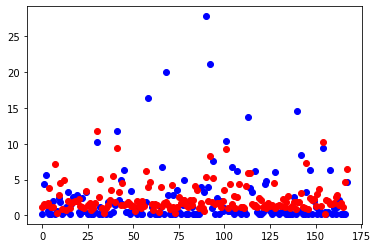

In [163]:
a = np.arange(0,168,1)
plt.plot(a, df['Actual'], 'bo')
plt.plot(a, df['Predicted'], 'ro')
plt.show()

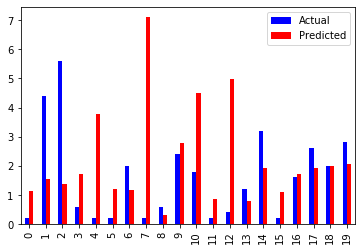

In [164]:
df.iloc[:20,:].plot(kind='bar', color=('blue', 'red'), legend=True );

**Regressão usando Random Forrest Regressor**

In [165]:
from sklearn.ensemble import RandomForestRegressor

# Setando 100 árvores de decisão
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Treinando o modelo
rf.fit(X_train, y_train);

In [166]:
# Fazendo as predições
predictions = rf.predict(X_test)

In [167]:
df2 = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

In [168]:
p = 0
while p < len(df2['Predicted']):
    if df2['Predicted'][p] < 0:
        df2['Predicted'][p] = 0
    
    p += 1

In [169]:
df2.head(10);

In [170]:
lista_actual2 = list(df2['Actual'])
lista_predicted2 = list(df2['Predicted'])

erros2 = []
k = 0
while k < len(lista_actual2):
    erros2.append(abs(lista_actual2[k] - lista_predicted2[k]))
    k += 1
    
print('O erro médio é:',np.mean(erros2))
print('O desvio padrão do erro é:', np.std(erros2))

O erro médio é: 2.3071666666666664
O desvio padrão do erro é: 3.0736175399268584


No handles with labels found to put in legend.


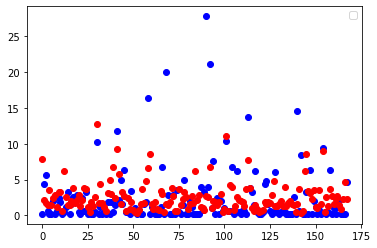

In [171]:
plt.plot(a, df2['Actual'], 'bo')
plt.plot(a, df2['Predicted'], 'ro')
plt.legend()
plt.show()

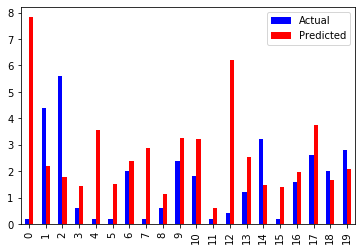

In [172]:
df2.iloc[:20,:].plot(kind='bar', color=('blue', 'red'), legend=True );